# Example for applying the adaptive variational algorithm on simulated data

In [17]:
import copy
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
module_path_2 = os.path.abspath(os.path.join('../..'))
module_path_3 = os.path.abspath(os.path.join('./Scalable_VB_Hawkes/'))
module_path_4 = os.path.abspath(os.path.join('./NHGPS/'))
if module_path not in sys.path:
    sys.path.append(module_path)
if module_path_2 not in sys.path:
    sys.path.append(module_path_2)
if module_path_3 not in sys.path:
    sys.path.append(module_path_3)
if module_path_4 not in sys.path:
    sys.path.append(module_path_4)

from src.NL_hawkes import NonlinHawkesBasis, LinkFunction
from src.utils import nb_excursions, gq_points_weights, nd_block_diag, intensity_process, log_likelihood

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy
from scipy.stats import gamma, norm, beta
from time import time
from scipy.special import expit
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
from scipy import optimize
import json
import pickle
import arviz as az
from types import SimpleNamespace
from pathlib import PosixPath
import yaml

### Create simulated data set

In [2]:
# General parameters
number_of_dimensions=1
number_of_basis=4
A=0.1
basis='histogram'
T=50
nl_models = {
    "sigmoid": {"theta": 0.0, "beta": 0.2, "eta": 10.0, "lamda":20.0 },
}
link = 'sigmoid'

In [3]:
# Model parameters
if number_of_dimensions > 1:
    base_activation = np.array([5., 4.0] * (number_of_dimensions // 2) ) # background rates
    graph_2D = np.array([[1, 1],[0, 1]], dtype=np.int64)
    graph = scipy.linalg.block_diag(*([graph_2D] * (number_of_dimensions //2))) # graph of interaction
    full_graph = np.ones((number_of_dimensions,number_of_dimensions), dtype=int)
    w01 = np.linspace(3,2,num=number_of_basis).reshape(1,-1)
    w02 = np.linspace(2,1,num=number_of_basis).reshape(1,-1)
    w03 = np.linspace(-3,-2,num=number_of_basis).reshape(1,-1)
    block_exc = np.concatenate([w01, w02, w02, w01], axis=0).reshape(2, 2, -1)
    block_inh = np.concatenate([w03, w02, w02, w03], axis=0).reshape(2, 2, -1)
    weight = {
        'exc': nd_block_diag([block_exc]*(number_of_dimensions//2)),
        'inh':  nd_block_diag([block_inh]*(number_of_dimensions//2)),
        }
else:
    base_activation = np.array([5.] )
    graph = np.array([[1]])
    w01 = np.linspace(3,2,num=number_of_basis).reshape(1,-1)
    w02 = np.linspace(2,1,num=number_of_basis).reshape(1,-1)
    w03 = np.linspace(-3,-2,num=number_of_basis).reshape(1,-1)
    block_exc = np.concatenate([w01, w02, w02, w01], axis=0).reshape(2, 2, -1)
    block_inh = np.concatenate([w03, w02, w02, w03], axis=0).reshape(2, 2, -1)
    weight = {
        'exc': w01,
        'inh': w03,
        }

N_param = len(base_activation) + weight['exc'].size
print("Number of model parameters : ", N_param)

# Choose scenario: excitation or inhibition
scenario = 'inh'

# Interaction functions
sparse_weight = np.expand_dims(graph, axis=2) * weight[scenario]

Number of model parameters :  5


In [4]:
# Initialise and simulate from process
model = SimpleNamespace(**nl_models[link])
t0 = time()
hawkes_model = NonlinHawkesBasis(number_of_dimensions, number_of_basis, A, model=link, basis=basis,
                              theta=model.theta, beta=model.beta, lamda=model.lamda, eta=model.eta)
hawkes_model.set_hawkes_parameters(base_activation, sparse_weight)
points_hawkes = hawkes_model.simulation(T=T)

# Remove "initial condition" to observe stationary distribution
T_init = 10
T = T - T_init
for d in range(len(points_hawkes)):
    points_hawkes[d] = points_hawkes[d][points_hawkes[d] > T_init] - T_init

# number of points on each dimension
N = np.array([len(points_hawkes[i]) for i in range(number_of_dimensions)])

print(f'Time for simulating the process: {time() - t0} sec')
print(f"Number of events : ", np.sum(N))
print(f"Number of excursions : ", nb_excursions(points_hawkes, A))

Time for simulating the process: 0.1366729736328125 sec
Number of events :  195
Number of excursions :  133


In [5]:
# Save dataset
save_dir_data = f'/data/hylacola/sulem/PycharmProjects/Scalable_VB_Hawkes/data/synthetic_data/dataset_histo_dim{number_of_dimensions}/'
save_dir_data = PosixPath(save_dir_data).expanduser()
if not os.path.isdir(save_dir_data):
    os.makedirs(save_dir_data)
with open(save_dir_data / f'data.p', 'wb') as fp:
    pickle.dump(points_hawkes, fp)

### Apply inference method

In [6]:
# Comparison with GP
# Run inference
yml_settings_file = f'./Scalable_VB_Hawkes/data/synthetic_data/dataset_histo_dim{number_of_dimensions}/input.yml'
res_dir = f'./Scalable_VB_Hawkes/results/synthetic_data/histo_dim{number_of_dimensions}/'
%run ./NHGPS/Experiments/inference/run.py --yml_file $yml_settings_file --output_path $res_dir

[CpuDevice(id=0)]
20230105-141009 ./Scalable_VB_Hawkes/data/synthetic_data/dataset_histo_dim1/input.yml
False
./Scalable_VB_Hawkes/results/synthetic_data/histo_dim1/20230105-141009
reading the following settings file: ./Scalable_VB_Hawkes/data/synthetic_data/dataset_histo_dim1/settings.yml
placing inducing points
placing integration points
init kernels
init mus and sigs


In [7]:
# Compute estimated VP
%run ./NHGPS/Experiments/estimate_s_g/run.py --yml_file $yml_settings_file --output_path $res_dir

1


In [8]:
# Compute estimated intensity
%run ./NHGPS/Experiments/calculate_predictive_intensity/run.py --yml_file $yml_settings_file --output_path $res_dir

./Scalable_VB_Hawkes/results/synthetic_data/histo_dim1/20230105-141025
Num trials:  1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255


In [9]:
# Load results
folder_path = './Scalable_VB_Hawkes/results/synthetic_data/histo_dim1/20230105-135000'
folder_path_2 = './Scalable_VB_Hawkes/results/synthetic_data/histo_dim1/20230105-135000'
inf_file = 'inference_results.p'
s_g_file = 's_g_res.p'
gen_data_file = 'data.p'
data_input_file = 'data_input.yml' # ground truth parameter and inference settings

with open(os.path.join(folder_path, inf_file), 'rb') as f:
    res = pickle.load(f)
LB_list, mu_g_X, mu_g2_X, hyper_params_list, \
 induced_points, integration_points, Kss_inv, ks_int_points, \
 ks_X, real_events, Sigma_g_s, mu_g_s, lmbda_star_q1, \
 alpha_q1, beta_q1 = res

with open(os.path.join(folder_path, s_g_file), 'rb') as f:
    grid, s, g, cov_s, cov_g = pickle.load(f)

    # s: estimated mean GP values for the time-varying background rate
    # cov_s: estimated cov matrix of GP

    # g and cov_g: same for interaction functions
var_g = np.maximum(1e-12, np.diag(cov_g)) # avoids numerical errors
var_s = np.maximum(1e-12, np.diag(cov_s))

with open(os.path.join(folder_path, gen_data_file), 'rb') as f:
    gen_data = pickle.load(f)

with open(os.path.join(folder_path, data_input_file), 'r') as stream:
    config = yaml.safe_load(stream)
    time_bound = config.get('time_bound')
    memory_decay = config.get('memory_decay')

vi_pred_int = os.path.join(folder_path_2, 'pred_int_res_.p')
with open(vi_pred_int, 'rb') as f:
    vi_grid, predictive_intensities_vi_mean, predictive_intensities_vi_var = pickle.load(f)

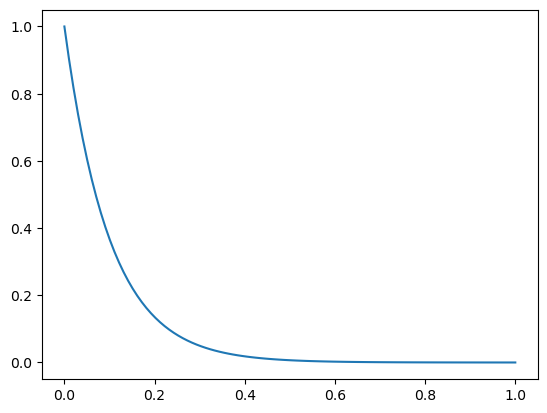

In [10]:
x = np.linspace(0,1.0,100)
y = np.exp(-10.0*x)
plt.plot(x,y)

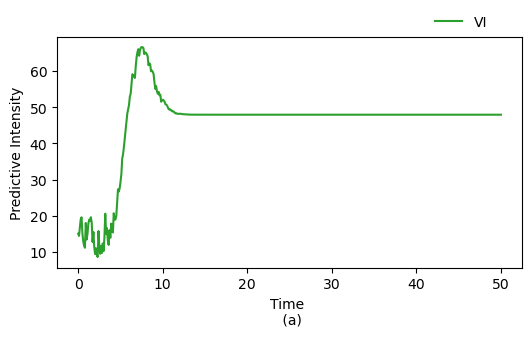

In [11]:
fig = plt.figure(figsize=(6,3))
gs = gridspec.GridSpec(1, 1)
gs.update(wspace=0.25, hspace=0.25)
ax1 = fig.add_subplot(gs[0, :2])
#ax1.plot(grid.flatten(), gt_pred_int.flatten(), label='Ground Truth', color='C3')
ax1.plot(vi_grid.flatten(), predictive_intensities_vi_mean, label='VI', color='#2ca02c')
#ax1.plot(real_events, np.zeros(0, len(real_events)), '|', color='C7', label='Observations')
ax1.set_xlabel('Time \n (a)')
ax1.set_ylabel('Predictive Intensity')
ax1.legend(loc='lower left', bbox_to_anchor= (0.8, 1.01), ncol=2,
        borderaxespad=0, frameon=False)

Text(0, 0.5, '$\\tilde{g}$')

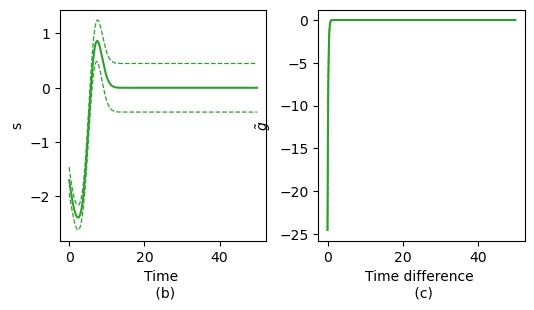

In [12]:
fig = plt.figure(figsize=(6,3))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.25, hspace=0.25)

ax2 = fig.add_subplot(gs[0, 0])
#ax2.plot(grid_s_gt, s_gt, color='C3', label='GT')
ax2.plot(grid, s, label='inference', color='#2ca02c')
ax2.plot(grid, s + np.sqrt(var_s), '--', color='#2ca02c', linewidth=0.9)
ax2.plot(grid, s - np.sqrt(var_s), '--', color='#2ca02c', linewidth=0.9)
ax2.set_xlabel('Time \n (b)')
ax2.set_ylabel('s')

ax3 = fig.add_subplot(gs[0, 1])
#ax3.plot(grid_g_gt, g_tilde_gt, color='C3', label='GT')
ax3.plot(grid, g, label='inference', color='#2ca02c')
ax3.plot(grid, g + np.sqrt(var_g), '--', color='#2ca02c', linewidth=0.9)
ax3.plot(grid, g - np.sqrt(var_g), '--', color='#2ca02c',linewidth=0.9)
ax3.set_xlabel('Time difference \n (c)')
ax3.set_ylabel(r'$\tilde{g}$')

In [13]:
res_path = './Scalable_VB_Hawkes/results/synthetic_data/histo_dim1/20230105-105445/inference_res.p'
with open(res_path, 'rb') as f:
    GP_res = pickle.load(f)

# list of ELBO values along iterations, mean VP values, etc
LB_list, mu_g_X, mu_g2_X, hyper_params_list, \
induced_points, integration_points, Kss_inv, ks_int_points, \
ks_X, real_events, Sigma_g_s, mu_g_s, lmbda_star_q1, \
alpha_q1, beta_q1 = GP_res

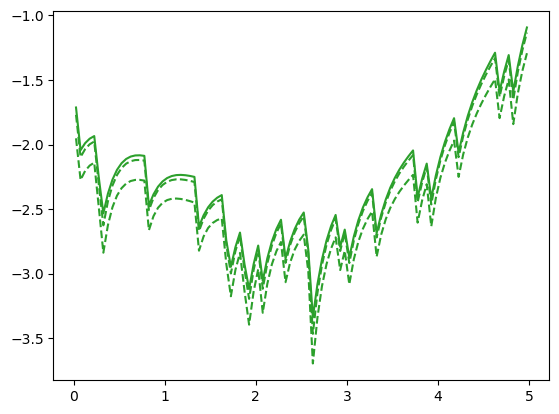

In [14]:
plt.plot(induced_points[0], mu_g_s,  color='#2ca02c')
plt.plot(induced_points[0], mu_g_s - np.sqrt(np.diag(Sigma_g_s)), '--',  color='#2ca02c')
plt.plot(induced_points[0], mu_g_s - np.diag(Sigma_g_s), '--',  color='#2ca02c')

In [15]:
# General prior parameters
mu = 0.0 # mean
sigma= 5.0 # variance

num_iter = 10 # number of VI iterations
depth = 3 # depth of nested histogram basis

num_gq = 5000 # number of Gaussian quadrature points
threshold = 0.05

In [16]:
# Run first algorithm
t0 = time()
mean_nu_1, mean_weight_1, cov_1 = hawkes_model.AdaptiveVB(points_hawkes, T=T, num_gq=num_gq, num_iter=num_iter, sigma=sigma, depth=depth)
mean_weight_1 = mean_weight_1.reshape(number_of_dimensions, number_of_dimensions, -1)
model_1 = hawkes_model.set_of_models[np.argmax(hawkes_model.vpost_proba)]
vi_model_1 = NonlinHawkesBasis(number_of_dimensions, model_1[1], A, model=link, basis=basis,
                               theta=model.theta, beta=model.beta, lamda=model.lamda, eta=model.eta)
vi_model_1.set_hawkes_parameters(mean_nu_1, mean_weight_1)
vi_model_1.set_of_models = hawkes_model.set_of_models
vi_model_1.vpost_proba = hawkes_model.vpost_proba

print(f'Time of first VI algo: {time() - t0} sec')
print(f'Estimated graph: ', model_1[0])
print(f'Number of basis functions: ', model_1[1])

TypeError: 'module' object is not callable

In [ ]:
# Run second algorithm
t0 = time()
mean_nu_2, mean_weight_2, cov_2 = hawkes_model.FastAdaptiveVB(points_hawkes, T=T, threshold=threshold, num_gq=num_gq, num_iter=num_iter, sigma=sigma, depth=depth)
mean_weight_2 = mean_weight_2.reshape(number_of_dimensions, number_of_dimensions, -1)
model_2 = hawkes_model.set_of_models[np.argmax(hawkes_model.vpost_proba)]
vi_model_2 = NonlinHawkesBasis(number_of_dimensions, model_2[1], A, model=link, basis=basis,
                               theta=model.theta, beta=model.beta, lamda=model.lamda, eta=model.eta)
vi_model_2.set_hawkes_parameters(mean_nu_2, mean_weight_2)
vi_model_2.set_of_models = hawkes_model.set_of_models
vi_model_2.vpost_proba = hawkes_model.vpost_proba
print(f'Time of second VI algo: {time() - t0} sec')
print(f'Estimated graph: ', model_2[0])
print(f'Number of basis functions: ', model_2[1])

### Visualise results

In [ ]:
# Estimated intensity using mean variational posterior estimate
Tmax = 10
points_hawkes_tmax = [points_hawkes[i][points_hawkes[i] < Tmax] for i in range(len(points_hawkes))]

# using first VI algorithm
vi_intensity_1, timestamps  = intensity_process(vi_model_1, points_hawkes_tmax)

# using second VI algorithm
vi_intensity_2, timestamps  = intensity_process(vi_model_2, points_hawkes_tmax)

# True intensity
true_intensity, timestamps = intensity_process(hawkes_model, points_hawkes_tmax)


fig, ax = plt.subplots(number_of_dimensions, 1, figsize=(10, 4))
for i in range(number_of_dimensions):
    if number_of_dimensions > 1:
        a = ax[i]
    else:
        a = ax
    a.plot(timestamps, true_intensity[i], label=f'truth', alpha=0.8, color='tab:green', linestyle='dashed')
    a.plot(timestamps,  vi_intensity_1[i], label=f'AVB_1', alpha=0.8, color='tab:orange')
    a.plot(timestamps, vi_intensity_2[i], label=f'AVB_2', alpha=0.8, color='tab:blue')
    a.set_xlabel('time')
    a.set_ylabel(rf'$\lambda^{i+1}_t$')
    a.grid()
a.legend()

In [ ]:
# Estimated parameter

# background rates
fig, ax = plt.subplots(1, number_of_dimensions, figsize=(4* number_of_dimensions,3))
for i in range(number_of_dimensions):
    if number_of_dimensions == 1:
        a = ax
    else:
        a = ax[i]
    x = np.linspace(mean_nu_1[i]-1, mean_nu_1[i]+1, 1000)
    q1_nu = norm.pdf(x, loc=mean_nu_1[i], scale=np.sqrt(cov_1[i][0,0]))
    a.plot(x, q1_nu, label='AVB_1')
    q2_nu = norm.pdf(x, loc=mean_nu_2[i], scale=np.sqrt(cov_2[i][0,0]))
    a.plot(x, q2_nu, label='AVB_2')
    a.set_ylim(0,max(max(q1_nu), max(q2_nu)))
    a.vlines(x=base_activation[i], ymin=0, ymax=max(max(q1_nu), max(q2_nu)), linestyles='dashed', label='truth', color='tab:green')
    a.legend(loc='upper left')
    a.grid(b=True)
    a.set_xlabel(rf'$\nu_{i+1}$')

# interaction functions
if basis == 'fourier':
    fb = Fourier(domain_range=[0, A], n_basis=number_of_basis,period=A)
elif basis == 'histogram':
    bins_true = np.linspace(0, A, num=number_of_basis+1)
else:
    raise ValueError
x = np.linspace(0, A, num=100)[:-1]
y_true = np.digitize(x, bins=bins_true) - 1

bins_m1 = np.linspace(0, A, num=model_1[1]+1)
y1 = np.digitize(x, bins=bins_m1) - 1
bins_m2 = np.linspace(0, A, num=model_2[1]+1)
y2 = np.digitize(x, bins=bins_m2) - 1

fig, ax = plt.subplots(number_of_dimensions,number_of_dimensions , figsize=(4*number_of_dimensions,3*number_of_dimensions))
for i in range(number_of_dimensions):
    for j in range(number_of_dimensions):
        if number_of_dimensions == 1:
            a = ax
        else:
            a = ax[i,j]

        std_w1 = np.sqrt(np.diag(cov_1[i]))[1+j*model_1[1]:1+(j+1)*model_1[1]]
        a.plot(x, mean_weight_1[i,j][y1], label='AVB_1', color='tab:orange')
        a.fill_between(x, (mean_weight_1[i,j] - 1.96*std_w1)[y1], (mean_weight_1[i,j] + 1.96*std_w1)[y1], alpha=0.3)

        std_w2 = np.sqrt(np.diag(cov_2[i]))[1+j*model_2[1]:1+(j+1)*model_2[1]]
        a.plot(x, mean_weight_2[i,j][y2], label='AVB_2', color='tab:blue')
        a.fill_between(x, (mean_weight_2[i,j] - 1.96*std_w2)[y2], (mean_weight_2[i,j] + 1.96*std_w2)[y2], alpha=0.3)

        a.plot(x, sparse_weight[i][j][y_true], label='truth',  color='tab:green', linestyle='dashed')
        a.set_xlabel(r'$x$')
        a.grid(b=True)
        id_latex=(i+1)*10+(j+1)
        a.set_ylabel(r'$h_{{{}}}(x)$'.format(id_latex))
a.legend()


In [ ]:
# 'Models' marginal probabilities
for i,m in enumerate(vi_model_1.set_of_models):
    if (m[0] == graph).all() and m[1] == number_of_basis:
        true_model1 = i

for i,m in enumerate(vi_model_2.set_of_models):
    if (m[0] == graph).all() and m[1] == number_of_basis:
        true_model2 = i

fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.set_title("Algo 1: marginal probabilities")
ax.bar(x=range(1,len(vi_model_1.vpost_proba)+1), height=vi_model_1.vpost_proba, color='tab:blue')
ax.scatter(x=range(1,len(vi_model_1.vpost_proba)+1), y=vi_model_1.vpost_proba, color='tab:blue')
ax.bar(x=true_model1+1, height=vi_model_1.vpost_proba[true_model1], color='tab:green', label="true model")
ax.scatter(x=true_model1+1, y=vi_model_1.vpost_proba[true_model1], color='tab:green')
ax.set_xlabel('model index')
ax.set_ylabel(r'$\hat \gamma_{s}$')
ax.set_ylim(-0.05, 1.1)
ax.set_xticks(np.arange(1,len(vi_model_1.vpost_proba),5))
ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.set_title("Algo 2: marginal probabilities")
ax.bar(x=range(1,len(vi_model_2.vpost_proba)+1), height=vi_model_2.vpost_proba, color='tab:orange')
ax.scatter(x=range(1,len(vi_model_2.vpost_proba)+1), y=vi_model_2.vpost_proba, color='tab:orange')
ax.bar(x=true_model2+1, height=vi_model_2.vpost_proba[true_model2], color='tab:green', label="true model")
ax.scatter(x=true_model2+1, y=vi_model_2.vpost_proba[true_model2], color='tab:green')
ax.set_xlabel('model index')
ax.set_ylabel(r'$\hat \gamma_{s}$')
ax.set_ylim(-0.05, 1.1)
ax.set_xticks(np.arange(1,len(vi_model_2.vpost_proba)+1,len(vi_model_2.vpost_proba)//5+1))
ax.legend()